In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.math as dali_math
from nvidia.dali import types
import numpy as np

In [2]:
import time

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.avg_last_n = 0
        self.max_val = 0

    def update(self, val, n=1):
        self.val = val
        self.max_val = max(self.max_val, val)
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def run_pipeline(pipe, epoch_size, batch_size, num_epochs=3, display_freq=8):
    
    num_iters = epoch_size // batch_size
    displ_period = num_iters // display_freq
    num_iters = displ_period * display_freq
    
    print(epoch_size // batch_size, num_iters)
    
    last_time = None

    for i in range(num_epochs):
        if i == 0:
            print("Warm up")
        else:
            print("Test run " + str(i))
        data_time = AverageMeter()
        end = time.time()
        for j in range(num_iters):
            stop_iter = False
            try:
                pipe.run()
            except StopIteration:
                assert j == num_iters - 1
                stop_iter = True
            if (j + 1) % displ_period == 0:
                data_time.update((time.time() - end) / displ_period)
                end = time.time()
                print("{}/ {}, avg time: {} [s], worst time: {} [s], speed: {} [img/s]".format(
                    j + 1,
                    num_iters,
                    data_time.avg,
                    data_time.max_val,
                    batch_size / data_time.avg,
                ))
        pipe.reset()
        last_time = batch_size / data_time.avg

    print("OK")
    return last_time

In [3]:
data_path = "/home/ktokarski/imgnet"

In [4]:
@pipeline_def
def read_images_pipeline(data_path, device="gpu"):
    images, labels = fn.readers.file(
        name="Reader",
        file_root=data_path,
        prefetch_queue_depth=1,
        random_shuffle=True,
        seed=42)
    images = fn.decoders.image(images, device="cpu" if device == "cpu" else "mixed", output_type=types.RGB)
    return images, labels

def synth_imgs_data(data_path, batch_size, device="gpu"):
    pipe = read_images_pipeline(
        data_path=data_path, num_threads=4, batch_size=batch_size, device_id=0, device=device)
    pipe.build()
    ress = [pipe.run() for _ in range(20)]
    def source():
        while True:
            for imgs, labls in ress:
                yield imgs, labls
    return source

In [5]:
@pipeline_def
def pipeline_box(cb, device="gpu", window_size=3):
    images, labels = fn.external_source(cb, device=device, num_outputs=2)
    filters = np.full((window_size, window_size), 1. / (window_size ** 2), dtype=np.float32)
    edges = fn.experimental.filter(images, filters)
    return edges, labels


@pipeline_def
def pipeline_sep_box(cb, device="gpu", window_size=3):
    images, labels = fn.external_source(cb, device=device, num_outputs=2)
    x_filt = np.full((1, window_size), 1. / window_size, dtype=np.float32)
    y_filt = np.full((window_size, 1), 1. / window_size, dtype=np.float32)
    x_images = fn.experimental.filter(images, x_filt)
    y_images = fn.experimental.filter(images, y_filt)
    return y_images, labels


@pipeline_def
def pipeline_gb(cb, device="gpu", window_size=3):
    images, labels = fn.external_source(cb, device=device, num_outputs=2)
    edges = fn.gaussian_blur(images, window_size=window_size)
    return edges, labels

In [6]:
def benchmark(pipeline, batch_size, window_size=3):
    device = "gpu"
    source = synth_imgs_data(data_path, batch_size=batch_size, device=device)
    pipe = pipeline(source, num_threads=4, batch_size=batch_size, device_id=0, device=device, window_size=window_size)
    pipe.build()
    epoch_size = 128 * 400
    return run_pipeline(pipe, epoch_size, batch_size, num_epochs=3)

In [7]:
box, box_sep, gb = [], [], []

In [8]:
box.append(benchmark(pipeline_box, 128, window_size=3))

400 400
Warm up
50/ 400, avg time: 0.00466578483581543 [s], worst time: 0.00466578483581543 [s], speed: 27433.755413976283 [img/s]
100/ 400, avg time: 0.0031156015396118166 [s], worst time: 0.00466578483581543 [s], speed: 41083.559104912994 [img/s]
150/ 400, avg time: 0.0025856939951578776 [s], worst time: 0.00466578483581543 [s], speed: 49503.15089090214 [img/s]
200/ 400, avg time: 0.0023211240768432617 [s], worst time: 0.00466578483581543 [s], speed: 55145.69482820605 [img/s]
250/ 400, avg time: 0.0021622962951660155 [s], worst time: 0.00466578483581543 [s], speed: 59196.32766617328 [img/s]
300/ 400, avg time: 0.002056902249654134 [s], worst time: 0.00466578483581543 [s], speed: 62229.500707446394 [img/s]
350/ 400, avg time: 0.001980254990713937 [s], worst time: 0.00466578483581543 [s], speed: 64638.14034062979 [img/s]
400/ 400, avg time: 0.0019234931468963623 [s], worst time: 0.00466578483581543 [s], speed: 66545.59711144977 [img/s]
Test run 1
50/ 400, avg time: 0.001525664329528808

In [9]:
box_sep.append(benchmark(pipeline_sep_box, 128, window_size=3))

400 400
Warm up
50/ 400, avg time: 0.0012931108474731445 [s], worst time: 0.0012931108474731445 [s], speed: 98986.10026365766 [img/s]
100/ 400, avg time: 0.0012636995315551758 [s], worst time: 0.0012931108474731445 [s], speed: 101289.90064788297 [img/s]
150/ 400, avg time: 0.0012600024541219075 [s], worst time: 0.0012931108474731445 [s], speed: 101587.10372449463 [img/s]
200/ 400, avg time: 0.001259157657623291 [s], worst time: 0.0012931108474731445 [s], speed: 101655.26074122042 [img/s]
250/ 400, avg time: 0.0012502670288085938 [s], worst time: 0.0012931108474731445 [s], speed: 102378.12967200611 [img/s]
300/ 400, avg time: 0.001245132287343343 [s], worst time: 0.0012931108474731445 [s], speed: 102800.32194258265 [img/s]
350/ 400, avg time: 0.0012551137379237585 [s], worst time: 0.00131500244140625 [s], speed: 101982.78939384481 [img/s]
400/ 400, avg time: 0.0012512129545211794 [s], worst time: 0.00131500244140625 [s], speed: 102300.73109256107 [img/s]
Test run 1
50/ 400, avg time: 0.

In [10]:
gb.append(benchmark(pipeline_gb, 128, window_size=3))

400 400
Warm up
50/ 400, avg time: 0.0072091627120971676 [s], worst time: 0.0072091627120971676 [s], speed: 17755.182551950533 [img/s]
100/ 400, avg time: 0.007171928882598877 [s], worst time: 0.0072091627120971676 [s], speed: 17847.360465406193 [img/s]
150/ 400, avg time: 0.00715968132019043 [s], worst time: 0.0072091627120971676 [s], speed: 17877.890687541876 [img/s]
200/ 400, avg time: 0.007150344848632813 [s], worst time: 0.0072091627120971676 [s], speed: 17901.23451521004 [img/s]
250/ 400, avg time: 0.007142237663269044 [s], worst time: 0.0072091627120971676 [s], speed: 17921.554285189337 [img/s]
300/ 400, avg time: 0.007137851715087891 [s], worst time: 0.0072091627120971676 [s], speed: 17932.56642323283 [img/s]
350/ 400, avg time: 0.0071322672707693924 [s], worst time: 0.0072091627120971676 [s], speed: 17946.60731862787 [img/s]
400/ 400, avg time: 0.007129687070846559 [s], worst time: 0.0072091627120971676 [s], speed: 17953.102110665517 [img/s]
Test run 1
50/ 400, avg time: 0.007

In [11]:
box.append(benchmark(pipeline_box, 128, window_size=7))

400 400
Warm up
50/ 400, avg time: 0.002722811698913574 [s], worst time: 0.002722811698913574 [s], speed: 47010.22845284275 [img/s]
100/ 400, avg time: 0.0027392363548278805 [s], worst time: 0.0027556610107421875 [s], speed: 46728.35178110903 [img/s]
150/ 400, avg time: 0.002731194496154785 [s], worst time: 0.0027556610107421875 [s], speed: 46865.94095741245 [img/s]
200/ 400, avg time: 0.0027238476276397706 [s], worst time: 0.0027556610107421875 [s], speed: 46992.34960911258 [img/s]
250/ 400, avg time: 0.002723369598388672 [s], worst time: 0.0027556610107421875 [s], speed: 47000.598110419305 [img/s]
300/ 400, avg time: 0.0027218516667683918 [s], worst time: 0.0027556610107421875 [s], speed: 47026.80956599381 [img/s]
350/ 400, avg time: 0.0027224670137677874 [s], worst time: 0.0027556610107421875 [s], speed: 47016.180307306284 [img/s]
400/ 400, avg time: 0.0027205145359039304 [s], worst time: 0.0027556610107421875 [s], speed: 47049.92320780604 [img/s]
Test run 1
50/ 400, avg time: 0.002

In [12]:
box_sep.append(benchmark(pipeline_sep_box, 128, window_size=7))

400 400
Warm up
50/ 400, avg time: 0.0015288448333740233 [s], worst time: 0.0015288448333740233 [s], speed: 83723.34275252478 [img/s]
100/ 400, avg time: 0.0014928269386291504 [s], worst time: 0.0015288448333740233 [s], speed: 85743.36159658349 [img/s]
150/ 400, avg time: 0.0014798148473103843 [s], worst time: 0.0015288448333740233 [s], speed: 86497.30757374446 [img/s]
200/ 400, avg time: 0.0014742445945739747 [s], worst time: 0.0015288448333740233 [s], speed: 86824.12706216452 [img/s]
250/ 400, avg time: 0.0014714107513427734 [s], worst time: 0.0015288448333740233 [s], speed: 86991.34479151409 [img/s]
300/ 400, avg time: 0.001481948693593343 [s], worst time: 0.0015346384048461914 [s], speed: 86372.76078001935 [img/s]
350/ 400, avg time: 0.0014842373984200615 [s], worst time: 0.0015346384048461914 [s], speed: 86239.57335683175 [img/s]
400/ 400, avg time: 0.0014807838201522827 [s], worst time: 0.0015346384048461914 [s], speed: 86440.70677841184 [img/s]
Test run 1
50/ 400, avg time: 0.00

In [13]:
gb.append(benchmark(pipeline_gb, 128, window_size=7))

400 400
Warm up
50/ 400, avg time: 0.007464814186096192 [s], worst time: 0.007464814186096192 [s], speed: 17147.111342491306 [img/s]
100/ 400, avg time: 0.0074618816375732425 [s], worst time: 0.007464814186096192 [s], speed: 17153.850223980266 [img/s]
150/ 400, avg time: 0.007454150517781575 [s], worst time: 0.007464814186096192 [s], speed: 17171.641449238403 [img/s]
200/ 400, avg time: 0.007442375421524048 [s], worst time: 0.007464814186096192 [s], speed: 17198.80988935495 [img/s]
250/ 400, avg time: 0.007434441566467285 [s], worst time: 0.007464814186096192 [s], speed: 17217.164040583524 [img/s]
300/ 400, avg time: 0.007431557973225911 [s], worst time: 0.007464814186096192 [s], speed: 17223.844644844692 [img/s]
350/ 400, avg time: 0.007430314336504255 [s], worst time: 0.007464814186096192 [s], speed: 17226.727457700024 [img/s]
400/ 400, avg time: 0.007429706454277039 [s], worst time: 0.007464814186096192 [s], speed: 17228.136910619745 [img/s]
Test run 1
50/ 400, avg time: 0.007414832

In [14]:
box.append(benchmark(pipeline_box, 128, window_size=11))

400 400
Warm up
50/ 400, avg time: 0.004792208671569824 [s], worst time: 0.004792208671569824 [s], speed: 26710.022199027066 [img/s]
100/ 400, avg time: 0.004758415222167968 [s], worst time: 0.004792208671569824 [s], speed: 26899.712199071666 [img/s]
150/ 400, avg time: 0.004749444325764973 [s], worst time: 0.004792208671569824 [s], speed: 26950.521202158438 [img/s]
200/ 400, avg time: 0.004742186069488525 [s], worst time: 0.004792208671569824 [s], speed: 26991.770909952003 [img/s]
250/ 400, avg time: 0.00474055290222168 [s], worst time: 0.004792208671569824 [s], speed: 27001.06984145505 [img/s]
300/ 400, avg time: 0.004742821852366129 [s], worst time: 0.004792208671569824 [s], speed: 26988.152619762124 [img/s]
350/ 400, avg time: 0.004739415986197335 [s], worst time: 0.004792208671569824 [s], speed: 27007.54700004729 [img/s]
400/ 400, avg time: 0.0047417312860488885 [s], worst time: 0.004792208671569824 [s], speed: 26994.35971342394 [img/s]
Test run 1
50/ 400, avg time: 0.004729375839

In [15]:
box_sep.append(benchmark(pipeline_sep_box, 128, window_size=11))

400 400
Warm up
50/ 400, avg time: 0.0018292713165283204 [s], worst time: 0.0018292713165283204 [s], speed: 69973.21766512176 [img/s]
100/ 400, avg time: 0.0017691779136657715 [s], worst time: 0.0018292713165283204 [s], speed: 72349.98753448231 [img/s]
150/ 400, avg time: 0.0017391602198282877 [s], worst time: 0.0018292713165283204 [s], speed: 73598.73951845437 [img/s]
200/ 400, avg time: 0.001726773977279663 [s], worst time: 0.0018292713165283204 [s], speed: 74126.66723276055 [img/s]
250/ 400, avg time: 0.001716416358947754 [s], worst time: 0.0018292713165283204 [s], speed: 74573.98045219644 [img/s]
300/ 400, avg time: 0.0017105491956075035 [s], worst time: 0.0018292713165283204 [s], speed: 74829.76831574882 [img/s]
350/ 400, avg time: 0.0017148630959647043 [s], worst time: 0.0018292713165283204 [s], speed: 74641.52695407618 [img/s]
400/ 400, avg time: 0.001709515452384949 [s], worst time: 0.0018292713165283204 [s], speed: 74875.01784287876 [img/s]
Test run 1
50/ 400, avg time: 0.0016

In [16]:
gb.append(benchmark(pipeline_gb, 128, window_size=11))

400 400
Warm up
50/ 400, avg time: 0.0077442598342895505 [s], worst time: 0.0077442598342895505 [s], speed: 16528.37104370512 [img/s]
100/ 400, avg time: 0.0077078151702880855 [s], worst time: 0.0077442598342895505 [s], speed: 16606.52171492274 [img/s]
150/ 400, avg time: 0.00770417054494222 [s], worst time: 0.0077442598342895505 [s], speed: 16614.377791004623 [img/s]
200/ 400, avg time: 0.007693749666213989 [s], worst time: 0.0077442598342895505 [s], speed: 16636.88130666557 [img/s]
250/ 400, avg time: 0.007692437171936036 [s], worst time: 0.0077442598342895505 [s], speed: 16639.71991438247 [img/s]
300/ 400, avg time: 0.007689634164174398 [s], worst time: 0.0077442598342895505 [s], speed: 16645.785386819218 [img/s]
350/ 400, avg time: 0.0076908820016043525 [s], worst time: 0.0077442598342895505 [s], speed: 16643.084625833373 [img/s]
400/ 400, avg time: 0.007686583399772644 [s], worst time: 0.0077442598342895505 [s], speed: 16652.39201122647 [img/s]
Test run 1
50/ 400, avg time: 0.0076

In [17]:
box.append(benchmark(pipeline_box, 128, window_size=15))

400 400
Warm up
50/ 400, avg time: 0.007770228385925293 [s], worst time: 0.007770228385925293 [s], speed: 16473.132273930907 [img/s]
100/ 400, avg time: 0.007774658203125 [s], worst time: 0.007779088020324707 [s], speed: 16463.746271000156 [img/s]
150/ 400, avg time: 0.0077605660756429025 [s], worst time: 0.007779088020324707 [s], speed: 16493.6421843939 [img/s]
200/ 400, avg time: 0.007760577201843261 [s], worst time: 0.007779088020324707 [s], speed: 16493.618537754894 [img/s]
250/ 400, avg time: 0.0077544527053833 [s], worst time: 0.007779088020324707 [s], speed: 16506.6452608757 [img/s]
300/ 400, avg time: 0.007750887076059976 [s], worst time: 0.007779088020324707 [s], speed: 16514.23878891892 [img/s]
350/ 400, avg time: 0.007748874936785015 [s], worst time: 0.007779088020324707 [s], speed: 16518.527017692042 [img/s]
400/ 400, avg time: 0.007748839259147643 [s], worst time: 0.007779088020324707 [s], speed: 16518.603073214315 [img/s]
Test run 1
50/ 400, avg time: 0.007739553451538086

In [18]:
box_sep.append(benchmark(pipeline_sep_box, 128, window_size=15))

400 400
Warm up
50/ 400, avg time: 0.00197993278503418 [s], worst time: 0.00197993278503418 [s], speed: 64648.65927142588 [img/s]
100/ 400, avg time: 0.001934952735900879 [s], worst time: 0.00197993278503418 [s], speed: 66151.48661003624 [img/s]
150/ 400, avg time: 0.0019194014867146812 [s], worst time: 0.00197993278503418 [s], speed: 66687.45485817538 [img/s]
200/ 400, avg time: 0.001917177438735962 [s], worst time: 0.00197993278503418 [s], speed: 66764.8165546916 [img/s]
250/ 400, avg time: 0.0019233570098876954 [s], worst time: 0.00197993278503418 [s], speed: 66550.30727107388 [img/s]
300/ 400, avg time: 0.0019188300768534343 [s], worst time: 0.00197993278503418 [s], speed: 66707.31376584369 [img/s]
350/ 400, avg time: 0.001913766860961914 [s], worst time: 0.00197993278503418 [s], speed: 66883.8000129564 [img/s]
400/ 400, avg time: 0.0019104254245758058 [s], worst time: 0.00197993278503418 [s], speed: 67000.78336134023 [img/s]
Test run 1
50/ 400, avg time: 0.00189023494720459 [s], w

In [19]:
gb.append(benchmark(pipeline_gb, 128, window_size=15))

400 400
Warm up
50/ 400, avg time: 0.008180880546569824 [s], worst time: 0.008180880546569824 [s], speed: 15646.237501129306 [img/s]
100/ 400, avg time: 0.00811619997024536 [s], worst time: 0.008180880546569824 [s], speed: 15770.927339057473 [img/s]
150/ 400, avg time: 0.008098691304524739 [s], worst time: 0.008180880546569824 [s], speed: 15805.022711322063 [img/s]
200/ 400, avg time: 0.008088511228561402 [s], worst time: 0.008180880546569824 [s], speed: 15824.91467008394 [img/s]
250/ 400, avg time: 0.008078928947448731 [s], worst time: 0.008180880546569824 [s], speed: 15843.684333976164 [img/s]
300/ 400, avg time: 0.008071266015370686 [s], worst time: 0.008180880546569824 [s], speed: 15858.726469458508 [img/s]
350/ 400, avg time: 0.008069622176034111 [s], worst time: 0.008180880546569824 [s], speed: 15861.95700464712 [img/s]
400/ 400, avg time: 0.008069338202476501 [s], worst time: 0.008180880546569824 [s], speed: 15862.515213542105 [img/s]
Test run 1
50/ 400, avg time: 0.008062028884

In [20]:
box.append(benchmark(pipeline_box, 128, window_size=51))

400 400
Warm up
50/ 400, avg time: 0.07787115097045899 [s], worst time: 0.07787115097045899 [s], speed: 1643.7409541892835 [img/s]
100/ 400, avg time: 0.07786834478378296 [s], worst time: 0.07787115097045899 [s], speed: 1643.8001906348159 [img/s]
150/ 400, avg time: 0.07786058266957602 [s], worst time: 0.07787115097045899 [s], speed: 1643.9640651445566 [img/s]
200/ 400, avg time: 0.0778609561920166 [s], worst time: 0.07787115097045899 [s], speed: 1643.956178554154 [img/s]
250/ 400, avg time: 0.07786192512512208 [s], worst time: 0.07787115097045899 [s], speed: 1643.9357207557782 [img/s]
300/ 400, avg time: 0.07786439895629883 [s], worst time: 0.07787676811218262 [s], speed: 1643.883491245333 [img/s]
350/ 400, avg time: 0.07786755425589427 [s], worst time: 0.07788648605346679 [s], speed: 1643.8168788422026 [img/s]
400/ 400, avg time: 0.07789573550224305 [s], worst time: 0.07809300422668457 [s], speed: 1643.222176088371 [img/s]
Test run 1
50/ 400, avg time: 0.08045495510101318 [s], worst 

In [21]:
box_sep.append(benchmark(pipeline_sep_box, 128, window_size=51))

400 400
Warm up
50/ 400, avg time: 0.0037949514389038087 [s], worst time: 0.0037949514389038087 [s], speed: 33729.021849347686 [img/s]
100/ 400, avg time: 0.0037889742851257326 [s], worst time: 0.0037949514389038087 [s], speed: 33782.22979830872 [img/s]
150/ 400, avg time: 0.003774669965108236 [s], worst time: 0.0037949514389038087 [s], speed: 33910.24942132383 [img/s]
200/ 400, avg time: 0.0037944388389587404 [s], worst time: 0.003853745460510254 [s], speed: 33733.5783847093 [img/s]
250/ 400, avg time: 0.003785783767700195 [s], worst time: 0.003853745460510254 [s], speed: 33810.700202182445 [img/s]
300/ 400, avg time: 0.0037961570421854653 [s], worst time: 0.003853745460510254 [s], speed: 33718.310011302856 [img/s]
350/ 400, avg time: 0.0037932048525129046 [s], worst time: 0.003853745460510254 [s], speed: 33744.55242384369 [img/s]
400/ 400, avg time: 0.003789963722229004 [s], worst time: 0.003853745460510254 [s], speed: 33773.41034935261 [img/s]
Test run 1
50/ 400, avg time: 0.0037637

In [22]:
gb.append(benchmark(pipeline_gb, 128, window_size=51))

400 400
Warm up
50/ 400, avg time: 0.01124063014984131 [s], worst time: 0.01124063014984131 [s], speed: 11387.261950061318 [img/s]
100/ 400, avg time: 0.011223690509796143 [s], worst time: 0.01124063014984131 [s], speed: 11404.448464458317 [img/s]
150/ 400, avg time: 0.01119943618774414 [s], worst time: 0.01124063014984131 [s], speed: 11429.146776163074 [img/s]
200/ 400, avg time: 0.011194268465042113 [s], worst time: 0.01124063014984131 [s], speed: 11434.4229281014 [img/s]
250/ 400, avg time: 0.011190069198608397 [s], worst time: 0.01124063014984131 [s], speed: 11438.713892485861 [img/s]
300/ 400, avg time: 0.01119010289510091 [s], worst time: 0.01124063014984131 [s], speed: 11438.679447356924 [img/s]
350/ 400, avg time: 0.011185908317565916 [s], worst time: 0.01124063014984131 [s], speed: 11442.968810945265 [img/s]
400/ 400, avg time: 0.011186806559562681 [s], worst time: 0.01124063014984131 [s], speed: 11442.050000460884 [img/s]
Test run 1
50/ 400, avg time: 0.011171650886535645 [s]

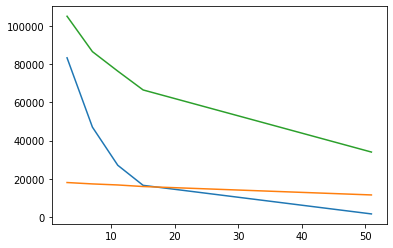

In [23]:
import matplotlib.pyplot as plt
# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs = [3, 7, 11, 15, 51]
ax.plot(xs, box, color='tab:blue')
ax.plot(xs, gb, color='tab:orange')
ax.plot(xs, box_sep, color='tab:green')
plt.show()

